## Import modules

In [2]:
#Import Modules
import os
import sys
import json
import nbib
import pandas as pd
import requests as rq
import matplotlib.pyplot as plt
from datetime import datetime
import pyperclip
import time

from bs4 import BeautifulSoup
from Bio import Entrez
Entrez.email = "your_email@example.com"

request_counter = 0
gene_counter = 0

if not os.path.exists('grpm_db'):
    os.makedirs('grpm_db')

## job forecast

In [3]:
#Statistiche basate su 150 random genes:
time_sleep = 0.4
runtime_gene = 6.36 #sec/gene
geni_ora = 566 #geni/ora
request_counter_gene = 4.25 #request/gene (with base sleep (0.4))
sleep_request_base = 0.4
sleep_request_overnight_plus = 1.1 #plus/gene

print('Previsioni:')
max_genes = int(10000/request_counter_gene)
print('max genes: ',max_genes)
table_size_db_gene = 0.496 #MB
table_size_gene = 0.397 #MB
png_size_db_gene = 0.47 #KB

#Previsioni:
genes = pd.read_csv('human_genes_repo/H_GENES_proteincoding_genes.csv')
ngenes = len(genes)#gene_range
nruntime = ngenes * runtime_gene
#print('runtime, '+str(ngenes), nruntime)
nrequest_counter = ngenes * request_counter_gene
print('request_counter, '+str(int(ngenes)),':', nrequest_counter)

tempo_ore = round(nruntime/3600, 2)
tempo_ore_overnight = round((nruntime+(sleep_request_overnight_plus*ngenes))/3600, 2)
print('runtime_hours, '+str(int(ngenes)),':', tempo_ore)
print('runtime_hours_overnight, '+str(int(ngenes)),':', tempo_ore_overnight)

db_table_size = ngenes * table_size_gene
print('db_table_size_MB, '+str(int(ngenes)),':', round(db_table_size,2))

Previsioni:
max genes:  2352
request_counter, 19383 : 82377.75
runtime_hours, 19383 : 34.24
runtime_hours_overnight, 19383 : 40.17
db_table_size_MB, 19383 : 7695.05


LOG: with na:
    protein_coding_genes 19383
    IG_TR_genes 660
    RNA_genes 14691
    pseudo_genes 13426
    misc_genes 55

dropna():
    protein_coding_genes 19318
    IG_TR_genes 641
    RNA_genes 11452
    pseudo_genes 9866
    misc_genes 22

https://www.howto-connect.com/automatically-hibernate-windows-10-scheduled-time/
Write the number of seconds replacing xx after which you want to hibernate your system in the below command –
    timeout /t xx /NOBREAK > NUL && shutdown /h

time start 17:00 --> time hybernation 00:01
    timeout /t 35000 /NOBREAK > NUL && shutdown /h

## load Human Genes

In [4]:
# Load Human Gene list
protein_coding_genes = pd.read_csv('human_genes_repo/H_GENES_proteincoding_genes.csv')
IG_TR_genes          = pd.read_csv('human_genes_repo/H_GENES_IGTR_genes.csv')
RNA_genes            = pd.read_csv('human_genes_repo/H_GENES_RNA_genes.csv')
pseudo_genes         = pd.read_csv('human_genes_repo/H_GENES_pseudo_genes.csv')
misc_genes           = pd.read_csv('human_genes_repo/H_GENES_misc_genes.csv')

#First: protein coding genes:
protein_coding_genes_list = protein_coding_genes['Gene name'].dropna().tolist()
RNA_genes_list = RNA_genes['Gene name'].dropna().tolist()
pseudo_genes_list = pseudo_genes['Gene name'].dropna().tolist()

#set source gene list
surce_gene_list = protein_coding_genes_list

#protein_coding_genes_list = list(map(str, protein_coding_genes_list))
#set interval
gene_range = int(len(surce_gene_list)/18)
gene_range = 2300
genes01 = surce_gene_list[:gene_range]
genes02 = surce_gene_list[gene_range:gene_range*2]
genes03 = surce_gene_list[gene_range*2:gene_range*3]
genes04 = surce_gene_list[gene_range*3:gene_range*4]
genes05 = surce_gene_list[gene_range*4:gene_range*5]
genes06 = surce_gene_list[gene_range*5:gene_range*6]
genes07 = surce_gene_list[gene_range*6:gene_range*7]
genes08 = surce_gene_list[gene_range*7:gene_range*8]
genes09 = surce_gene_list[gene_range*8:gene_range*9]
slicer = 1150
genes02_01 = genes02[:slicer]
genes02_02 = genes02[ slicer:]
genes03_01 = genes03[:slicer]
genes03_02 = genes03[ slicer:]
genes04_01 = genes04[:slicer]
genes04_02 = genes04[ slicer:]
genes05_01 = genes05[:slicer]
genes05_02 = genes05[ slicer:]
genes06_01 = genes06[:slicer]
genes06_02 = genes06[ slicer:]
genes07_01 = genes07[:slicer]
genes07_02 = genes07[ slicer:]
genes08_01 = genes08[:slicer]
genes08_02 = genes08[ slicer:]
genes09_01 = genes09[:slicer]

#Second: RNA genes:
rna_genes_list = RNA_genes['Gene name'].dropna().tolist()
rnagenes01 = rna_genes_list[:gene_range]
rnagenes02 = rna_genes_list[gene_range:gene_range*2]
rnagenes02_01 = rnagenes02[:1150]
rnagenes02_02 = rnagenes02[1150:]
#genes1, genes2
#protein_coding_genes[:20]
pyperclip.copy(str(rnagenes02_01))

print('protein_coding_genes',len(protein_coding_genes['Gene name'].dropna()),
      '\nIG_TR_genes',len(IG_TR_genes['Gene name'].dropna()),
      '\nRNA_genes',len(RNA_genes['Gene name'].dropna()),
      '\npseudo_genes',len(pseudo_genes['Gene name'].dropna()),
      '\nmisc_genes',len(misc_genes['Gene name'].dropna()))

len(rnagenes02_01)

protein_coding_genes 19318 
IG_TR_genes 641 
RNA_genes 11452 
pseudo_genes 9866 
misc_genes 22


1150

stack = 1150 + 0
#genes04_01 = genes04[111:1150]
pyperclip.copy(str(genes04_01))
len(genes04_01)

## set parameters
## import datasets

In [5]:
# set parameters:--------------------------------
save_studytype_data = False
save_plot           = False
save_accessory_data = False
db_tag = 'trial'
db_name = 'grpm_db'+'_'+db_tag
#------------------------------------------------

if not os.path.exists(db_name):
    os.makedirs(db_name)

# create/import datasheet
time_a = datetime.now()
if os.path.isfile(db_name+'/grpm_table_output.csv'):
    complete_df = pd.read_csv(db_name+'/grpm_table_output.csv', index_col=0)
else:
    complete_df = pd.DataFrame()

if os.path.isfile(db_name+'/complete_nbibtable.csv'):
    complete_nbibtable = pd.read_csv(db_name+'/complete_nbibtable.csv', index_col=0)
else:
    complete_nbibtable = pd.DataFrame()
time_b = datetime.now()

print('time load',time_b-time_a)

time load 0:00:00.001273


## check data

In [7]:
# check data
if os.path.isfile(db_name+'/grpm_table_output.csv'):
    gene_db_count =  complete_df.gene.nunique()
    print('complete_df gene count:',gene_db_count,'on', len(surce_gene_list))
    if gene_db_count >= 15519:
        print('grpm db already contains all available genes on litvar1')

    print('\ngrpm_table_output.csv size'  ,round(os.path.getsize(db_name+'/grpm_table_output.csv')/(1024*1024),3),'MB')
    print('complete_nbibtable.csv size',round(os.path.getsize(db_name+'/complete_nbibtable.csv')/(1024*1024),3),'MB')
    print('memory_usage_complete_df'     ,round(complete_df.memory_usage().sum()/(1024*1024),3))
    print('memory_usage_complete_nbib_df',round(complete_nbibtable.memory_usage().sum()/(1024*1024),3))
else:
    print('empty database')

empty database


# Run Job

In [8]:
#Get modulule

# Set gene range
genes = pd.Series(genes01).sample(5)
#when stucked use this:
skipped_genes =  []
#genes = ['APOA1', 'FFC1', 'ERH', 'USP53']
pyperclip.copy(str(genes))

time_start = datetime.now()
print('Start at ',time_start)

# get gene data
for i in genes:
    #LitVar2 "Variants for Gene" API request
    if request_counter > 9950:
        #print('Request limit reached. Wait \'till tomorrow!')
        #break
        pass
    gene = i
    time_alpha = datetime.now()
    url = "https://www.ncbi.nlm.nih.gov/research/litvar2-api/variant/search/gene/" + gene
    foo = (rq.get(url)).text

    # parsing output in JSON
    foo = foo.replace("\n",", ")
    foo = foo.replace("\'","\"")
    foo = foo.replace('\"\"', '\"')
    foo = foo.replace('p.\"','p.')
    foo = foo.replace('c.\"','c.')
    foo = foo.replace('g.\"','g.')
    foo = foo.replace('\">','>')
    foo = foo.replace('.C\"204','.C204')



    data="[" + foo + "]"

    #Create Dataframe
    df = pd.read_json(data)
    if 'rsid' in df.columns and len(df.rsid)>1:
        # creare un df senza i clingen.
        dfb = df[['_id','pmids_count','rsid']]
        dfa = dfb[~dfb['_id'].str.contains('@CA')].drop_duplicates().reset_index(drop=True)
        dfn = dfa.dropna(subset=['rsid'])

        #Statistics
        handle = Entrez.esearch(db="snp", term=gene)
        record = Entrez.read(handle)
        request_counter += 1

        NCBI_dbSNP = record["Count"]
        lit2_variant = len(dfa['_id'].drop_duplicates())
        lit2_variant_norsid = len(dfa.loc[df['rsid'].isna()])
        lit2_rsid = len(dfn.rsid.drop_duplicates())

        #^print('Statistics, LitVar2:')
        #^print("Gene:", gene)
        #^print('NCBI dbSNP:', NCBI_dbSNP, 'rsid for', gene,'gene') #search gnomad api
        #^print("variant_count:", lit2_variant)
        #^print('variant without rsid:', lit2_variant_norsid)
        #^print("rsid_count:", lit2_rsid)#, 'diff:', int(record["Count"])-len(dfn))

        # remove rs with pmid_count=1
        df2 = dfn.loc[df.pmids_count !=1]#.reset_index(drop=True)
        lit2_rsid_f = len(df2)

        #^print("rsid_count(pmid>1):", lit2_rsid_f)#, 'diff:', len(dfn)-len(df2)
        dfsort = df.sort_values(by='pmids_count',ascending=False).reset_index(drop=True)
        df2sort = df2.sort_values(by='pmids_count',ascending=False).reset_index(drop=True)
        #^display(df2sort[["rsid","pmids_count"]].head(15))


        #LitVar1 POST rsid2pmids
        # convert in "data" for POST request
        liss = list(map(str, df.rsid))
        qrsid = "\", \"".join(liss)
        qrsid = '{"rsids": ["'+ qrsid +'"]}'

        url="https://www.ncbi.nlm.nih.gov/research/bionlp/litvar/api/v1/public/rsids2pmids"
        headers={ "Content-Type" : "application/json", "Accept" : "application/json"}

        # inserire i miei data=rsID list
        data = qrsid
        #data = {["rs781028867", "rs17817449"]}
        r = rq.post(url, headers=headers, data=data )
        if not r.ok:
            r.raise_for_status()
            sys.exit()
        rspost = r.json()

        #Display
        dfrspost = pd.DataFrame(rspost)
        if 'rsid' in dfrspost.columns and len(dfrspost.rsid)>1:
            lit1_rsid = len(dfrspost.rsid)
            #lit2_rsid = len(df)

            #^print('Statistics, LitVar1:')
            #^print('LitVar1 rsid:', lit1_rsid)
            #^print('LitVar2 rsid:',lit2_rsid_f,'(diff:', len(df2)-len(dfrspost.rsid),')')
            lit1_raw_pmid = 0
            for i in range(len(dfrspost)):
                lit1_raw_pmid += len(dfrspost.pmids[i])
            #^print('raw pmid_count:', lit1_raw_pmid)
            #^display(dfrspost[["rsid","pmids"]].head(10))


            #Creare la lista semplice [rsid-pmid]
            #[MODULO: "Alligner"]
            rspmid = []
            for i in range(len(dfrspost)):
                for pmid in dfrspost['pmids'][i]: #dfrspost = mother table
                    out = dfrspost['rsid'][i], pmid
                    rspmid.append(out)

            rsidpmid = pd.DataFrame(rspmid).drop_duplicates().rename(columns={0: 'rsid',1:'pmids'})
            rsidpmid['pmids'] = rsidpmid['pmids'].astype(str) #convert pmid type in str
            #report data:
            lit1_rsid_pmid = len(rsidpmid)
            lit1_pmid = len(rsidpmid.drop_duplicates(subset='pmids'))
            #^print("total [rsid-pmid]:",len(rsidpmid))
            #^print('rsid_count:', lit1_rsid)
            #^print('pmid_count:',lit1_pmid)
            #print('\n',rsidpmid.head(10))

            ####[MODULO: groupby.describe]
            # applicare groupby ad rsidpmid per avere tabella pmid count
            rsidpmidcount = rsidpmid.groupby('rsid').describe().reset_index()
            rsidpmidcount.columns = rsidpmidcount.columns.to_flat_index()
            #replace column names
            new_column_names = ['rsid', 'pmid_count', 'pmid_unique','pmid_top','pmid_freq']
            rsidpmidcount.columns = new_column_names
            rsidpmidcountf = rsidpmidcount[['rsid','pmid_unique']]
            #report data:
            lit1_rsid_f = len(rsidpmidcountf[rsidpmidcountf.pmid_unique!=1])
            lit1_rsid_m = len(rsidpmidcountf[rsidpmidcountf.pmid_unique==1])
            #^print ('\nrsid (pmid>1):',lit1_rsid_f)
            #^print ('rsid (pmid=1)',lit1_rsid_m)

            rsidpmidcountfsort = rsidpmidcountf.sort_values('pmid_unique',ascending=False).reset_index(drop=True)
            #^print('\n',rsidpmidcountfsort.head(10))

            #Filter pmid for rsid with pmid>1
            outless = rsidpmidcountfsort[rsidpmidcountfsort.pmid_unique>1]
            #creare una mask isin su rsidpmid con outless.rsid
            mask = rsidpmid['rsid'].isin(outless.rsid)
            rsidpmidless = rsidpmid[mask]
            lit1_pmid_f = len(rsidpmidless.pmids.drop_duplicates())
            #^print('\nLitVar1 results:')
            #^print('total rsid:', lit1_rsid)
            #^print('filtered rsid (pmid>1):',lit1_rsid_f)
            #^print('total pmids:', lit1_pmid)
            #^print('filtered pmids:',lit1_pmid_f)
            #rsidpmidless

            # PubMed query Build:
            ### two input alternatives (total LitVar1 and LitVar>1)
            #Total
            pmdq1 = rsidpmid.pmids.drop_duplicates().tolist()
            #^print(gene,'pmids:',len(pmdq1))

            #pmid>1
            pmdq2 = rsidpmidless.pmids.drop_duplicates().tolist()
            pmdq2 = list(map(str, pmdq2))
            #^print(gene,'pmids (n>1):',len(pmdq2))

            #Query chunk build (max:1300)
            ##https://www.entechin.com/python-split-list/
            limit = 1300

            if len(pmdq1)<=limit:
                wkl01 = pmdq1

            if limit<len(pmdq1)<=limit*2:
                j = len(pmdq1)//2
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:]

            if limit*2<len(pmdq1)<=limit*3:
                j = len(pmdq1)//3
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:j*2]
                wkl03=pmdq1[j*2:]

            if limit*3<len(pmdq1)<=limit*4:
                j = len(pmdq1)//4
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:j*2]
                wkl03=pmdq1[j*2:j*3]
                wkl04=pmdq1[j*3:]

            if limit*4<len(pmdq1)<=limit*5:
                j = len(pmdq1)//5
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:j*2]
                wkl03=pmdq1[j*2:j*3]
                wkl04=pmdq1[j*3:j*4]
                wkl05=pmdq1[j*4:]

            if limit*5<len(pmdq1)<=limit*6:
                j = len(pmdq1)//6
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:j*2]
                wkl03=pmdq1[j*2:j*3]
                wkl04=pmdq1[j*3:j*4]
                wkl05=pmdq1[j*4:j*5]
                wkl06=pmdq1[j*5:]

            if limit*6<len(pmdq1)<=limit*7:
                j = len(pmdq1)//7
                wkl01=pmdq1[:j]
                wkl02=pmdq1[j:j*2]
                wkl03=pmdq1[j*2:j*3]
                wkl04=pmdq1[j*3:j*4]
                wkl05=pmdq1[j*4:j*5]
                wkl06=pmdq1[j*5:j*6]
                wkl07=pmdq1[j*6:]

            #if len(pmdq1)>limit*7:
            #print('pmid query out of range')

            #^print('\npmid query1:',len(wkl01))
            #if limit<len(pmdq1)<limit*2:
            #print('pmid query2:',len(wkl02))
            #print('sum:',len(wkl01+wkl02))
            #if limit*2<len(pmdq1)<limit*3:
            #print('pmid query2:',len(wkl02))
            #print('pmid query3:',len(wkl03))
            #print('sum:',len(wkl01+wkl02+wkl03))

            ##Define list of queries for PubMed:
            query = []

            if len(pmdq1)<limit:
                query01 = "+OR+".join(wkl01)
                query = [query01]

            if limit<len(pmdq1)<limit*2:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                #print('chunks2:',len(wkl01+wkl02))
                query = [query01, query02]

            if limit*2<len(pmdq1)<limit*3:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                query03 = "+OR+".join(wkl03)
                #print('chunks3:',len(wkl01+wkl02+wkl03))
                query = [query01, query02, query03]

            if limit*3<len(pmdq1)<limit*4:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                query03 = "+OR+".join(wkl03)
                query04 = "+OR+".join(wkl04)
                query = [query01, query02, query03, query04]

            if limit*4<len(pmdq1)<limit*5:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                query03 = "+OR+".join(wkl03)
                query04 = "+OR+".join(wkl04)
                query05 = "+OR+".join(wkl05)
                query = [query01, query02, query03, query04, query05]

            if limit*5<len(pmdq1)<limit*6:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                query03 = "+OR+".join(wkl03)
                query04 = "+OR+".join(wkl04)
                query05 = "+OR+".join(wkl05)
                query06 = "+OR+".join(wkl06)
                query = [query01, query02, query03, query04, query05,query06]

            if limit*6<len(pmdq1)<limit*7:
                query01 = "+OR+".join(wkl01)
                query02 = "+OR+".join(wkl02)
                query03 = "+OR+".join(wkl03)
                query04 = "+OR+".join(wkl04)
                query05 = "+OR+".join(wkl05)
                query06 = "+OR+".join(wkl06)
                query07 = "+OR+".join(wkl07)
                query = [query01, query02, query03, query04, query05,query06, query07]

            #print(type(query), len(query))
            #^print('pages:', (len(wkl01)//200)+1)

            # Concatenzaione delle request per le due query
            ### carefull: high runtime
            #^print('nbib report:', gene)
            #^print('start  at:', datetime.now())
            time1 = datetime.now()
            pages = ((len(wkl01)//200)+1)+1
            if len(wkl01) % 200 == 0:
                pages = pages -1
            fullnbib = str()
            for d in query:
                for i in range(1,pages):
                    page = str(i)
                    url = 'https://pubmed.ncbi.nlm.nih.gov/?term=' + d + '&format=pubmed&size=200&page='+ page
                    output = rq.get(url)
                    html = output.text
                    soup = BeautifulSoup(html, features="html.parser")
                    for script in soup(["script", "style"]):
                        script.extract()
                    text = soup.get_text()
                    postString = text.split("\n\n\n\n\n\n\n\n\n\n",2)[2]
                    nbib01 = postString.replace('\n\n','')
                    fullnbib += nbib01
                    request_counter += pages
                    time.sleep(1.5)
                #if pages>6:
                #print(gene+' slept for 1 sec every pubmed query')
                #time.sleep(1)
                #else:
                #    pass
            time2 = datetime.now()
            timestamp = time2.strftime('%Y%m%d%H%M%S')
            #^print('finish at:', datetime.now())
            runtime = time2-time1
            duration = str(runtime).split('.')[0]
            hours, minutes, seconds = duration.split(':')
            compact_duration = '{}:{}:{}'.format(hours, minutes, seconds)
            #^print('runtime', duration)
            #print(fullnbib)

            # nbib parsing:
            timea = datetime.now()
            ref = nbib.read(fullnbib)
            dfbib = pd.DataFrame(ref)
            if 'descriptors' in dfbib.columns and len(dfbib['descriptors'])>1:
                dfbibdes = dfbib[['pubmed_id','descriptors']].dropna().reset_index(drop=True)
                nbib_objects = len(dfbib)
                nbib_objects_withdescriptors = len(dfbibdes)
                #^print('nibib objects:',nbib_objects)
                #^print('nibib objects with descriptors:',len(dfbibdes))
                timeb = datetime.now()
                #^print('runtime:', timeb-timea)

                #INFO: all nbib qualifier;
                #dfbib.loc[1]

                #Statistics:
                pubmed_pmid_query = len(pmdq1)
                pubmed_pmid_nbib = len(dfbib.pubmed_id.drop_duplicates())
                pubmed_pmid_nbib_yesmesh = len(dfbibdes.pubmed_id.drop_duplicates())
                pubmed_pmid_nbib_nomesh = len(dfbib.pubmed_id.drop_duplicates())-len(dfbibdes.pubmed_id.drop_duplicates())

                #^print('\nPubMed scraping:', gene, time1)
                #^print('pmid in query:',pubmed_pmid_query)
                #^print(f"pmid in nbib: {pubmed_pmid_nbib}")
                #^print('   pmid with mesh:', pubmed_pmid_nbib_yesmesh)
                #^print('   pmid without mesh:', pubmed_pmid_nbib_nomesh)
                #print('   rsid for pmid with-mesh:', 'vedi dopo')
                #display(dfbibdes.head(5))

                dfr = []
                for i in range(len(dfbibdes)):
                    for mesh in dfbibdes['descriptors'][i]:
                        out = dfbibdes['pubmed_id'][i], mesh
                        dfr.append(out)
                MESH = pd.DataFrame(dfr).rename(columns={0: 'pmids',1:'mesh'})

                # dataframe parsing splitting three fields
                MESHsplit =[]
                for i in range(len(MESH)):
                    #mg = dict(MESH2.mesh[i]).get('descriptor')
                    mg = MESH.mesh[i].get('descriptor')
                    mg2 = MESH.mesh[i].get('qualifier')
                    mg3 = MESH.mesh[i].get('major')
                    mgg = MESH.pmids[i], mg, mg2, mg3
                    MESHsplit.append(mgg)

                dfmesh = pd.DataFrame(MESHsplit).rename(columns={0: 'pmids',1:'mesh',2:'qualifier',3:'major'}).drop_duplicates()

                #statistics
                pubmed_pmidmesh = len(dfmesh[['pmids','mesh']].drop_duplicates())
                pubmed_mesh_qualifier_major = len(MESH.mesh.drop_duplicates())
                pubmed_mesh = len(dfmesh.mesh.drop_duplicates())

                #print('\npmid-with-mesh:',len(MESH.pmids.drop_duplicates()))
                #^print('\n[pmid-mesh]_count:',pubmed_pmidmesh)
                #^print('[mesh-qualifier-major]_count:',pubmed_mesh_qualifier_major)
                #^print('[mesh]_count:',pubmed_mesh)

                #simple dataframe [pmid-mesh]
                #^print('\nreminder:')
                #^print(gene,'rsid litvar1 (pmid>1):', lit1_rsid_f)
                #^print('pmid litvar1 (pmid>1):', lit1_pmid_f)

                pmidmesh = dfmesh[['pmids','mesh']].drop_duplicates()
                pmidmesh['pmids'] = pmidmesh['pmids'].astype(str) #convert pmid type in str
                #^display(dfmesh.head(20))
                #dfmesh.to_csv(''+gene+' pmid-mesh.csv')

                #Analyze enrichment with groupby.describe method------------------------------------------
                #Add rsid coulmn con merge
                rspmidmesh_merge = pd.merge(pmidmesh, rsidpmid, on= 'pmids', how='inner').drop_duplicates().reindex(columns=['pmids', 'rsid', 'mesh'])
                #rspmidmesh_merge['pmids'] = rspmidmesh_merge['pmids'].astype(str)

                ### groupby.describe analysis by mesh
                meshrspmidmerge_count = rspmidmesh_merge.groupby('mesh').describe().reset_index()
                meshrspmidmerge_count.columns = meshrspmidmerge_count.columns.to_flat_index()
                #to handle generate df.groupby.describe, convert Multicolumn to single column
                #https://datascientyst.com/flatten-multiindex-in-pandas/
                new_column_names = ['mesh', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq','rsid-count', 'rsid-unique','rsid-top','rsid-freq']
                meshrspmidmerge_count.columns = new_column_names

                meshrspmidmerge_count_short = meshrspmidmerge_count[['mesh','pmid-unique','rsid-unique']]
                #pmidmeshintmerge2meshlesssort = pmidmeshintmerge2meshless.sort_values(by='pmid-unique',ascending=False).reset_index(drop=True)

                # add frequency
                totalpmid_count = len(pmidmesh.pmids.drop_duplicates())
                meshrspmidmerge_count_short_freq = meshrspmidmerge_count_short.copy()
                meshb_frq = meshrspmidmerge_count_short_freq.loc[:,'pmid-unique'].astype(float)/totalpmid_count
                meshrspmidmerge_count_short_freq.loc[:,'mesh frequency'] = round(meshb_frq,3)#*100
                meshrspmidmerge_count_short_freq_sort = meshrspmidmerge_count_short_freq.sort_values(by='pmid-unique',ascending=False).reset_index(drop=True)

                top10mesh_all = meshrspmidmerge_count_short_freq_sort['mesh'][:10].tolist()
                #display(meshrspmidmerge_count_short_freq_sort.head(20))

                ### groupby.describe analysis by rsid------------------
                rspmidmeshmerge_count = rspmidmesh_merge.groupby('rsid').describe().reset_index()
                rspmidmeshmerge_count.columns = rspmidmeshmerge_count.columns.to_flat_index()
                new_column_names = ['rsid', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq','mesh-count', 'mesh-unique','mesh-top','mesh-freq']
                rspmidmeshmerge_count.columns = new_column_names

                rsid_pmid10 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>10])
                rsid_pmid50 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>50])
                rsid_pmid100 = len(rspmidmeshmerge_count[rspmidmeshmerge_count['pmid-unique']>100])

                rspmidmeshmerge_count_short = rspmidmeshmerge_count[['rsid','pmid-unique','mesh-unique']]
                rspmidmeshmerge_count_short_sort = rspmidmeshmerge_count_short.sort_values(by='pmid-unique', ascending= False).reset_index(drop=True)
                top10rsid_all = rspmidmeshmerge_count_short_sort['rsid'].iloc[:10].tolist()

                if save_plot == True:
                    # create a scatter plot-----------------------------------------
                    x1 = meshrspmidmerge_count_short_freq_sort['mesh'].head(30)
                    y1 = meshrspmidmerge_count_short_freq_sort['pmid-unique'].head(30)
                    plt.figure(figsize=(5, 8))
                    plt.title('Scatter Plot: '+gene+' pmid-mesh (total)', loc='center',pad=10)
                    plt.scatter(y1, x1)
                    plt.gca().invert_yaxis()
                    #plt.yticks(rotation=90)
                    plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
                    plt.xlabel('pmid count', position=(0.5, 1.08))
                    ax = plt.gca()
                    ax.xaxis.set_label_position('top')
                    plt.savefig(db_name+'/'+gene+'_mesh_plot_'+timestamp+'_total.png',dpi=120, bbox_inches = "tight")
                    plt.close()

                if save_studytype_data == True:
                    # GET STUDY TYPE from NBIB----------------------------------------
                    dfbib = pd.DataFrame(ref)
                    dfbib.pubmed_id = dfbib.pubmed_id.astype('str')
                    if 'publication_types' in dfbib.columns and len(dfbib['publication_types'])>1:
                        dfbib_studyty = dfbib[['pubmed_id','publication_types']].dropna().reset_index(drop=True)

                        #PMID-Studytype table build:
                        df_studytype = []
                        for i in range(len(dfbib_studyty)):
                            for studytype in dfbib_studyty['publication_types'][i]:
                                out = dfbib_studyty['pubmed_id'][i], studytype
                                df_studytype.append(out)
                        STUDYT = pd.DataFrame(df_studytype).rename(columns={0: 'pmids',1:'study_type'})
                        mask_st = STUDYT['study_type'].str.contains('Research Support|Journal Article')
                        STUDYTless = STUDYT[~mask_st].reset_index(drop=True)

                        mask_lessing = STUDYT['pmids'].isin(STUDYTless['pmids'])
                        STUDYTdiff = STUDYT[~mask_lessing].reset_index(drop=True)
                        STUDYTdiff['study_type2'] = 'Unknown'
                        STUDYTdiff = STUDYTdiff[['pmids','study_type2']].rename(columns={'study_type2':'study_type'}).drop_duplicates().reset_index(drop=True)
                        #len(STUDYTless.pmids.drop_duplicates()), len(dfbib.pubmed_id.drop_duplicates())
                        STUDYTconcat = pd.concat([STUDYTless, STUDYTdiff], ignore_index=True)
                        STUDYTconcat#.pmids.drop_duplicates()

                        #study type count:
                        STUDYTless_count = STUDYTconcat.groupby('study_type').describe().reset_index()
                        STUDYTless_count.columns = STUDYTless_count.columns.to_flat_index()
                        new_column_names = ['study_type', 'pmid-count', 'pmid-unique','pmid-top','pmid-freq']
                        STUDYTless_count.columns = new_column_names
                        STUDYTless_count_sort = STUDYTless_count.sort_values(by= 'pmid-count',ascending=False)

                        # save data
                        STUDYTconcat.to_csv(db_name+'/'+gene+'_lit1pmid_studytype.csv')
                    else:
                        print(gene+' no publication_types in nbib')
                        pass

#SAVE TABLES-----------------------------------------------------------
                timestamp = time2.strftime('%Y%m%d%H%M%S')
                # save accessory data:
                if save_accessory_data == True:
                    dfsort[["_id","rsid","pmids_count"]].to_csv(db_name+'/'+gene+'_litvar2_variants4gene.csv')
                    rsidpmid.to_csv(db_name+'/'+gene+'_litvar1_rsids2pmids.csv') #lit1 [rsid-pmid]
                    #rsidpmidcountfsort #lit1 pmid count

                    meshrspmidmerge_count_short_freq_sort.to_csv(db_name+'/'+gene+'_mesh_pmidrsid_count.csv')

                #complete_df with concat:
                #import gene-rsidpmidmesh and gene-rsidpmid
                dfmesh['pmids'] = dfmesh['pmids'].astype(str)
                rsidpmid['pmids'] = rsidpmid['pmids'].astype(str)

                # add a rsid-merger to dfmesh
                gene_rsidpmidmesh = pd.merge(rsidpmid, dfmesh, on='pmids')
                gene_rsidpmidmesh['gene'] = gene

                gene_df = pd.DataFrame(gene_rsidpmidmesh)
                complete_df = pd.concat([complete_df, gene_rsidpmidmesh])

                #complete_nbibtable with concat:
                dfbib['gene'] = gene
                complete_nbibtable = pd.concat([complete_nbibtable, dfbib])
                #pyperclip.copy(str(dfbib.columns.to_list()))

                #old storage method
                    #dfmesh.to_csv(db_name+'/'+gene+'_pubmed_pmidmesh.csv')
                    #dfbib.to_csv(db_name+'/'+gene+'_nbib_table.csv')

#REPORT-----------------------------------------------------------------
                time_omega = datetime.now()
                full_runtime = time_omega - time_alpha
                #^print('total runtime:', full_runtime)
                print(gene + '_runtime:', full_runtime)
                nbib_seconds = runtime.total_seconds()
                total_seconds = full_runtime.total_seconds()
                full_runtime_str = str(full_runtime).split('.')[0]

                report = {'ncbi_dbsnp': NCBI_dbSNP,
                          'lit2_variant': lit2_variant,
                          'lit2_variant_norsid': lit2_variant_norsid,
                          'lit2_rsid': lit2_rsid,
                          'lit2_rsid_plus1': lit2_rsid_f,
                          'lit1_rsid': lit1_rsid,
                          #'lit1_raw_pmid': lit1_raw_pmid,
                          #'lit1_rsid_pmid': lit1_rsid_pmid,
                          'lit1_rsid_pmid_plus1': lit1_rsid_f,
                          #lit1_rsid_pmid=1': lit1_rsid_m,
                          'lit1_pmid': lit1_pmid,
                          'lit1_pmid_pmid_plus1': lit1_pmid_f,
                          'pubmed_pmid_query': pubmed_pmid_query,
                          'nbib_objects': nbib_objects,
                          'nbib_objects_withdescriptors': nbib_objects_withdescriptors,
                          'pubmed_pmid': pubmed_pmid_nbib,
                          'pubmed_pmid_withmesh': pubmed_pmid_nbib_yesmesh,
                          #'pubmed_pmid_nomesh':pubmed_pmid_nbib_nomesh,
                          'pubmed_pmidmesh': pubmed_pmidmesh,
                          'pubmed_mesh_qualifier_major': pubmed_mesh_qualifier_major,
                          'pubmed_mesh': pubmed_mesh,
                          'rsid_pmid10': rsid_pmid10,
                          'rsid_pmid50': rsid_pmid50,
                          'rsid_pmid100': rsid_pmid100,
                          'top10mesh_all': str(top10mesh_all),
                          'top10rsid_all': str(top10rsid_all),
                          'pubmed_runtime': duration,
                          'total_runtime': full_runtime_str,
                          'time_stamp': time2
                          }

                df_report = pd.DataFrame(report, index=[gene]).transpose()

                # generate fist report.csv
                if os.path.isfile(db_name+'/GRPM_report.csv'):
                    dfL = pd.read_csv(db_name+'/GRPM_report.csv', index_col=0)
                    dfL = pd.concat([dfL, df_report], axis=1)
                    dfL.to_csv(db_name+'/GRPM_report.csv')
                else:
                    df_report.to_csv(db_name+'/GRPM_report.csv')  # solo la prima volta

                #Update gene values
                GRPM_report = pd.read_csv(db_name+'/GRPM_report.csv', index_col=0)
                if gene + '.1' in GRPM_report.columns:
                    GRPM_report = GRPM_report.drop(columns=gene)
                    GRPM_report = GRPM_report.rename(columns={gene + '.1': gene})
                    GRPM_report.to_csv(db_name+'/GRPM_report.csv')
                    print(gene,'already in db')

            else:
                print(gene + ' no descriptors in nbib')
                time.sleep(0.8)
                pass
        else:
            print(gene + ' no results on litvar1')
            time.sleep(0.8)
            pass
    else:
        print(gene + ' no results on litvar2')
        pass

    if request_counter > 9000:
        dada = 2
        #print('Allert! Reaching pubmed request limit')
    if request_counter > 9950:
        #print('Request limit reached. Wait \'till tomorrow!')
        time_finish = datetime.now()
        time_batch = time_finish - time_start
        time_batch_str = str(time_batch).split('.')[0]
        #print('time batch:', time_batch_str)
        #break

complete_df = complete_df.reindex(columns=['gene','rsid', 'pmids', 'mesh', 'qualifier', 'major'])
complete_df.to_csv(db_name+'/grpm_table_output.csv')

complete_nbibtable = complete_nbibtable.reindex(columns=['gene','pubmed_id', 'citation_owner', 'nlm_status', 'last_revision_date', 'electronic_issn', 'linking_issn', 'journal_volume', 'journal_issue', 'publication_date', 'title', 'abstract', 'authors', 'language', 'grants', 'publication_types', 'electronic_publication_date', 'place_of_publication', 'journal_abbreviated', 'journal', 'nlm_journal_id', 'descriptors', 'pmcid', 'keywords', 'conflict_of_interest', 'received_time', 'revised_time', 'accepted_time', 'pubmed_time', 'medline_time', 'entrez_time', 'pii', 'doi', 'publication_status', 'print_issn', 'pages'])
complete_nbibtable.to_csv(db_name+'/complete_nbibtable.csv')

time_finish = datetime.now()
time_batch = time_finish - time_start
time_batch_str = str(time_batch).split('.')[0]
print('gene batch:', len(genes))
print('time batch:', time_batch_str)
print('runtime/gene:', time_batch/len(genes))
print('request_counter:', request_counter,' (limit: 10.000/day)')
gene_counter += len(genes)
print('requests/gene:', request_counter/gene_counter)
print(time_finish)

###LIMITS PubMed Programming Utilities (PMU)
#10 requests/second
#10,000 requests/day

#ChatGPT:As an AI language model, I should advise you that web scraping of PubMed is not allowed as it violates PubMed's terms of service.
# PubMed provides an API called PubMed Programming Utilities (PMU) that allows developers to access PubMed data programmatically. Using the API is the preferred way to obtain data from PubMed.
# Web scraping of PubMed may result in your IP address being temporarily or permanently blocked from accessing PubMed data. It is important to respect PubMed's terms of service and guidelines when accessing their data to avoid any legal repercussions.

Start at  2023-05-24 10:52:42.764731
ZNF343_runtime: 0:00:04.397493
ZBTB7C_runtime: 0:00:04.907892
PHF1_runtime: 0:00:04.174417
FAM25C no results on litvar1
OR10V1 no results on litvar1
gene batch: 5
time batch: 0:00:18
runtime/gene: 0:00:03.765850
request_counter: 11  (limit: 10.000/day)
requests/gene: 2.2
2023-05-24 10:53:01.593980


In [14]:
print('grpm report:')
display(pd.read_csv(db_name+'/GRPM_report.csv', index_col=0).T)
print('grpm table genes:', len(pd.read_csv(db_name+'/grpm_table_output.csv').gene.drop_duplicates()))
display(pd.read_csv(db_name+'/grpm_table_output.csv'))
#print('nbib table:')
#display(pd.read_csv(db_name+'/complete_nbibtable.csv',index_col=0))


grpm report:


,ncbi_dbsnp,lit2_variant,lit2_variant_norsid,lit2_rsid,lit2_rsid_plus1,lit1_rsid,lit1_rsid_pmid_plus1,lit1_pmid,lit1_pmid_pmid_plus1,pubmed_pmid_query,...,pubmed_mesh_qualifier_major,pubmed_mesh,rsid_pmid10,rsid_pmid50,rsid_pmid100,top10mesh_all,top10rsid_all,pubmed_runtime,total_runtime,time_stamp
BCAP29,18129,136,1,135,55,2,2,26,26,26,...,175,114,1,0,0,"['Humans', 'Genetic Predisposition to Disease'...","['rs10953541', 'rs199915614']",0:00:02,0:00:04,2023-05-19 12:41:00.754889
OSR1,6508,118,57,59,21,3,1,9,8,9,...,130,100,0,0,0,"['Transcription Factors', 'Humans', 'Animals',...","['rs12329305', 'rs1221411052', 'rs45535040']",0:00:01,0:00:03,2023-05-19 12:41:04.514054
UGT3A1,19620,284,0,282,152,10,4,16,11,16,...,138,109,0,0,0,"['Humans', 'Genome-Wide Association Study', 'A...","['rs3756669', 'rs201087553', 'rs10045685', 'rs...",0:00:01,0:00:03,2023-05-19 12:41:08.519351
CCL14,2217,417,354,59,31,8,3,14,9,14,...,145,108,0,0,0,"['Humans', 'Female', 'Male', 'Molecular Sequen...","['rs1315324929', 'rs139591348', 'rs2376291', '...",0:00:01,0:00:04,2023-05-19 12:41:12.635431
SLAIN2,34290,202,3,199,57,3,2,6,5,6,...,83,57,0,0,0,"['Humans', 'Inflammatory Bowel Diseases', 'Gen...","['rs6837335', 'rs146342071', 'rs7438704']",0:00:01,0:00:04,2023-05-19 12:45:14.280506
PRRC2A,9505,566,64,491,180,41,17,64,54,64,...,421,283,1,0,0,"['Humans', 'Polymorphism, Single Nucleotide', ...","['rs1046089', 'rs2260000', 'rs3130626', 'rs115...",0:00:02,0:00:05,2023-05-19 12:45:19.498881
KPNA7,32823,224,0,221,72,8,3,20,16,20,...,190,138,0,0,0,"['Humans', 'Genetic Predisposition to Disease'...","['rs9297145', 'rs7809799', 'rs587777539', 'rs1...",0:00:02,0:00:04,2023-05-19 12:45:24.140442
PRH2,3005,66,1,64,32,4,1,6,4,6,...,55,48,0,0,0,"['Humans', 'Male', 'Female', 'Genotype', 'Gene...","['rs1049112', 'rs10492100', 'rs1130408', 'rs29...",0:00:01,0:00:03,2023-05-19 12:45:28.288739
ZYX,5266,242,20,220,76,8,1,8,2,8,...,54,45,0,0,0,"['Animals', 'Polymorphism, Single Nucleotide',...","['rs11772895', 'rs4859', 'rs6464548', 'rs75359...",0:00:01,0:00:03,2023-05-19 12:45:32.060837
RPS18,3049,139,58,79,30,12,1,13,2,13,...,104,87,0,0,0,"['Humans', 'Female', 'Genome-Wide Association ...","['rs17215231', 'rs149067310', 'rs213203', 'rs4...",0:00:02,0:00:03,2023-05-19 12:49:59.483222


grpm table genes: 13


,Unnamed: 0,gene,rsid,pmids,mesh,qualifier,major
0,0,BCAP29,rs10953541,29695241,"Adaptor Proteins, Signal Transducing",genetics,False
1,1,BCAP29,rs10953541,29695241,Apolipoproteins E,genetics,False
2,2,BCAP29,rs10953541,29695241,Case-Control Studies,NaN,False
3,3,BCAP29,rs10953541,29695241,Collagen Type IV,genetics,False
4,4,BCAP29,rs10953541,29695241,Comorbidity,NaN,False
...,...,...,...,...,...,...,...
4077,539,FDFT1,rs757441747,33810292,"Drug Resistance, Fungal",drug effects,True
4078,540,FDFT1,rs757441747,33810292,Fungi,drug effects,True
4079,541,FDFT1,rs757441747,33810292,Fungi,physiology,True
4080,542,FDFT1,rs757441747,33810292,Humans,NaN,False


In [48]:
pd.Series(genes).to_clipboard(index= False)
pyperclip.copy(str(genes.to_list()))

In [8]:
data

'[{"_id": "litvar@rs980408##", "pmids_count": 1, "rsid": "rs980408"}, {"_id": "litvar@rs980407##", "pmids_count": 1, "rsid": "rs980407"}, {"_id": "litvar@rs980406##", "pmids_count": 1, "rsid": "rs980406"}, {"_id": "litvar@rs946218360##", "pmids_count": 1, "rsid": "rs946218360"}, {"_id": "litvar@rs8072363##", "pmids_count": 15, "rsid": "rs8072363"}, {"_id": "litvar@rs79165523##", "pmids_count": 1, "rsid": "rs79165523"}, {"_id": "litvar@rs780469382##", "pmids_count": 1, "rsid": "rs780469382"}, {"_id": "litvar@rs776411860##", "pmids_count": 2, "rsid": "rs776411860"}, {"_id": "litvar@rs774258991##", "pmids_count": 1, "rsid": "rs774258991"}, {"_id": "litvar@rs767427194##", "pmids_count": 5, "rsid": "rs767427194"}, {"_id": "litvar@rs766825520##", "pmids_count": 1, "rsid": "rs766825520"}, {"_id": "litvar@rs756934964##", "pmids_count": 1, "rsid": "rs756934964"}, {"_id": "litvar@rs755568057##", "pmids_count": 4, "rsid": "rs755568057"}, {"_id": "litvar@rs754781155##", "pmids_count": 1, "rsid": "

OG
on genes1_part1 (1187)
    no results on
        litvar: 214
        litvar2: 43
        litvar1: 126
        nbib: 11

on genes1_part2 (---)
    no results on
        litvar: 230
        litvar2: 27
        litvar1: 201
        nbib: 13

In [3]:
# Visualize GRPM_report.csv
GRPM_report = pd.read_csv(db_name+'/GRPM_report.csv', index_col=0).transpose().reset_index().rename(columns={'index':'gene'})

GRPM_report[['ncbi_dbsnp', 'lit2_variant', 'lit2_variant_norsid','lit2_rsid','lit2_rsid_plus1', 'lit1_rsid', 'lit1_rsid_pmid_plus1','lit1_pmid', 'lit1_pmid_pmid_plus1','pubmed_pmid_query',    'nbib_objects', 'nbib_objects_withdescriptors', 'pubmed_pmid',              'pubmed_pmid_withmesh', 'pubmed_pmidmesh','pubmed_mesh_qualifier_major','pubmed_mesh', 'rsid_pmid10','rsid_pmid50', 'rsid_pmid100' ]] = GRPM_report[['ncbi_dbsnp','lit2_variant', 'lit2_variant_norsid','lit2_rsid', 'lit2_rsid_plus1','lit1_rsid', 'lit1_rsid_pmid_plus1', 'lit1_pmid','lit1_pmid_pmid_plus1', 'pubmed_pmid_query','nbib_objects', 'nbib_objects_withdescriptors', 'pubmed_pmid', 'pubmed_pmid_withmesh', 'pubmed_pmidmesh', 'pubmed_mesh_qualifier_major', 'pubmed_mesh', 'rsid_pmid10', 'rsid_pmid50', 'rsid_pmid100' ]].astype(int)

#display(GRPM_report_less.sort_values(by= 'matching_pmids',ascending=False))
GRPM_report.sort_values(by='lit1_pmid',ascending = False)

,gene,ncbi_dbsnp,lit2_variant,lit2_variant_norsid,lit2_rsid,lit2_rsid_plus1,lit1_rsid,lit1_rsid_pmid_plus1,lit1_pmid,lit1_pmid_pmid_plus1,...,pubmed_mesh_qualifier_major,pubmed_mesh,rsid_pmid10,rsid_pmid50,rsid_pmid100,top10mesh_all,top10rsid_all,pubmed_runtime,total_runtime,time_stamp
249,TNF,1840,1842,1543,237,119,122,65,4287,4260,...,11485,3991,17,7,5,"['Humans', 'Female', 'Male', 'Tumor Necrosis F...","['rs1800629', 'rs361525', 'rs1799964', 'rs1799...",0:01:51,0:02:15,2023-03-14 11:33:43.998754
1657,BDNF,25241,582,178,353,193,153,85,3956,3934,...,8647,3208,27,4,2,"['Humans', 'Male', 'Female', 'Brain-Derived Ne...","['rs6265', 'rs2030324', 'rs11030104', 'rs10767...",0:02:00,0:02:25,2023-03-14 12:54:46.408228
2250,COMT,12898,730,154,527,222,151,79,3753,3739,...,7502,2810,22,6,5,"['Humans', 'Female', 'Male', 'Catechol O-Methy...","['rs4680', 'rs4818', 'rs4633', 'rs165599', 'rs...",0:02:03,0:02:25,2023-03-15 15:06:23.198010
6146,APP,116492,5822,3772,1785,671,469,265,3724,3659,...,9237,3459,22,12,8,"['Humans', 'Alzheimer Disease', 'Animals', 'Am...","['rs63750264', 'rs371425292', 'rs572842823', '...",0:01:34,0:02:07,2023-03-17 17:11:43.666506
7793,ABCB1,79458,2636,1008,1454,661,518,204,3077,3030,...,8416,3000,19,5,3,"['Humans', 'Female', 'Male', 'Polymorphism, Si...","['rs1045642', 'rs1128503', 'rs2032582', 'rs222...",0:01:38,0:02:03,2023-03-19 15:45:59.771136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8088,ATP6V0C,4623,50,14,35,12,2,0,2,0,...,27,25,0,0,0,"['Adult', 'Middle Aged', 'Telomerase', 'Select...","['rs369475799', 'rs773216583']",0:00:02,0:00:04,2023-03-19 16:22:12.229763
5363,ACTRT1,1179,69,2,65,25,2,1,2,2,...,23,10,0,0,0,"['Carcinoma, Basal Cell', 'Cilia', 'Ciliopathi...",['rs771087307'],0:00:01,0:00:03,2023-03-17 13:12:19.062024
4963,MRPL50,5418,77,1,76,26,2,0,2,0,...,22,20,0,0,0,"['Adult', 'Aged', 'Transforming Growth Factor ...",['rs1287015612'],0:00:01,0:00:03,2023-03-16 16:36:42.630130
24,NPBWR2,3244,129,5,124,58,4,0,1,0,...,23,17,0,0,0,"['Adolescent', 'Male', 'Underage Drinking', 'S...","['rs13036542', 'rs35368587', 'rs4809401', 'rs9...",0:00:01,0:00:03,2023-03-13 17:32:24.177529


<Figure size 640x480 with 0 Axes>

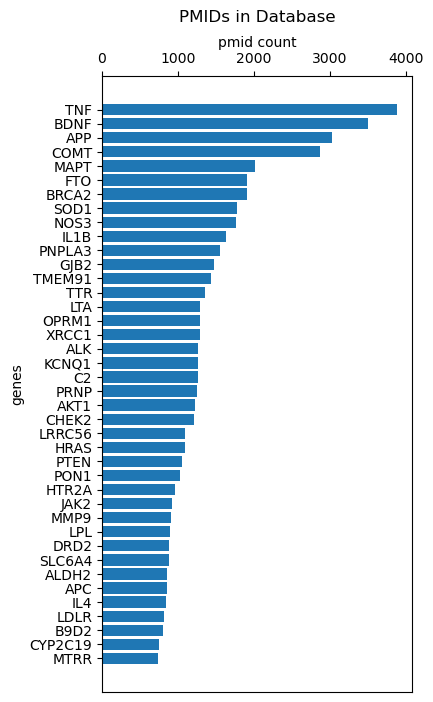

In [37]:
plt.clf()
# create histogram
GRPM_report_sort = GRPM_report.sort_values(by= 'pubmed_pmid',ascending=False)
#GRPM_report_sort = GRPM_report_01.sort_values(by= 'pubmed_pmid',ascending=False)

x = GRPM_report_sort.gene.iloc[:40]
y = GRPM_report_sort['pubmed_pmid'].iloc[:40]
plt.figure(figsize=(4, 8))
plt.title('PMIDs in Database', loc='center',pad=10)

plt.barh(x,y)
plt.gca().invert_yaxis()
plt.tick_params(axis='x', which='both', top=True, bottom=False, labeltop=True, labelbottom=False)
#plt.xlabel('pmid count', position=(0.5, 1.08))
plt.ylabel('genes')
plt.xlabel('pmid count', position=(0.5, 1.08))
ax = plt.gca()
ax.xaxis.set_label_position('top')
#plt.savefig(r'C:\Users\Public\Database_SSD\GRPX_heavyload (RunOnly)\logs\Database_Gene('+str(len(GRPM_filtered_report.gene))+')-PMID_filtered.png',dpi=300, bbox_inches = "tight")
#plt.clf()

In [37]:
#NBIB PROBLEM SOLVER---------------------------------
# #replace malformed lines
fullnbib= fullnbib.replace('2007/09/31','2007/09/30')
ref = nbib.read(fullnbib)
dfbib = pd.DataFrame(ref)

FileNotFoundError: [Errno 2] No such file or directory: 'nbib report MTRR_FIXED.txt'

#NBIB PROBLEM SOLVER [History] ---------------------------------
with open('nbib report '+gene+'.txt', 'w', encoding='utf-8') as file:
    file.write(fullnbib)
with open('nbib report '+gene+'_FIXED.txt', 'r', encoding='utf-8') as file:
    fullnbib = file.read() # --> not work

In [10]:
# Visualize GENES in DATABASE
# Get gene to Analyze
gene_list = pd.Series(GRPM_report.gene).to_list()
#gene_list.to_clipboard(index=False)
import pyperclip
pyperclip.copy(str(gene_list))

AttributeError: 'DataFrame' object has no attribute 'gene'

['MT-ND1', 'MT-ND2', 'MT-CO1', 'MT-CO2', 'MT-ATP8']

In [ ]:
#CODE DUMP-------------------------------------------------
### EUTILS GET STUDY TYPE MODULE
#https://biopython.org/docs/1.76/api/Bio.Entrez.html
def get_study_type(pmids):
    Entrez.email = 'your_email@your_domain.com'
    handle = Entrez.esummary(db='pubmed', id=','.join(pmids), retmode='xml')
    records = Entrez.parse(handle)
    study_types = []
    for record in records:
        article_types = record['PubTypeList']
        if 'Randomized Controlled Trial' in article_types:
            study_types.append('Randomized Controlled Trial')
        elif 'Controlled Clinical Trial' in article_types:
            study_types.append('Controlled Clinical Trial')
        elif 'Cohort Studies' in article_types:
            study_types.append('Cohort Study')
        elif 'Case-Control Studies' in article_types:
            study_types.append('Case-Control Study')
        elif 'Review' in article_types:
            study_types.append('Review')
        elif 'Clinical Trial' in article_types:
            study_types.append('Clinical Trial')
        elif 'Meta-Analysis' in article_types:
            study_types.append('Meta-Analysis')
        elif 'Multicenter Study' in article_types:
            study_types.append('Multicenter Study')
        else:
            study_types.append('Unknown')
    return study_types

pmidlist = list(pmidmesh['pmids'].drop_duplicates())
genepmids_str = list(map(str, pmidlist))
study_type = get_study_type(genepmids_str)
pmids_studytype = pd.DataFrame(list(zip(genepmids_str, study_type)), columns=[gene + '_PMID', 'study type'])
request_counter += 1

#study type count:
pmids_studytype_count = pmids_studytype.groupby('study type').describe().reset_index()
pmids_studytype_count.columns = pmids_studytype_count.columns.to_flat_index()
new_column_names = ['study_type', 'pmid-count', 'pmid-unique', 'pmid-top', 'pmid-freq']
pmids_studytype_count.columns = new_column_names
pmids_studytype_countsort = pmids_studytype_count.sort_values(by='pmid-count', ascending=False)